In [1]:
from tools.project import INPUT_PATH, LOGS_PATH, OUTPUT_PATH
import audiocraft
from audiocraft.models import MusicGen
from audiocraft.utils.notebook import display_audio
import torch
from gradio.cli.commands.components.publish import colors
from omegaconf import DictConfig
from torch import set_grad_enabled
from torch.onnx.symbolic_opset9 import tensor
from torchviz import make_dot
import typing as tp
from audiocraft.modules.conditioners import ConditioningAttributes
import tqdm
import torch
from audiocraft.data.audio import audio_read, audio_write
from audiocraft.data.audio_utils import convert_audio_channels, convert_audio
import umap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from src.util_tools import compute_cross_entropy
from torch.utils.tensorboard import SummaryWriter
from sklearn.decomposition import PCA
from random import shuffle
EXP_NUM = 1
EXAMPLES_LEN = 5
print(torch.backends.mps.is_available())

True


In [2]:
model = MusicGen.get_pretrained('facebook/musicgen-small')
model.set_generation_params(
	use_sampling=True,
	top_k=250,
	duration=EXAMPLES_LEN
)

/Users/mszawerda/Library/Caches/pypoetry/virtualenvs/musicgen-YATmys4o-py3.9/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [33]:
def get_music(idxs):
	songs = []
	for p in idxs:
		music, sr = audio_read(INPUT_PATH('textual-inversion', 'fma', f'music_p{p}.wav'), duration=EXAMPLES_LEN, pad=True)
		music = music[None]
		songs.append(convert_audio(music, sr, 32000, 1))
	with torch.no_grad():
		encoded_music, _ = model.compression_model.encode(torch.concatenate(songs))
	return encoded_music
train_ds = get_music(range(0, 20))
val_ds = get_music(range(30, 40))

In [4]:
new_token="S*"
text_conditioner=list(model.lm.condition_provider.conditioners.values())[0]
tokenizer=text_conditioner.t5_tokenizer
text_model=text_conditioner.t5
new_token_id = tokenizer.convert_tokens_to_ids(new_token)

if tokenizer.add_tokens([new_token]) == 1:
	text_model.resize_token_embeddings(len(tokenizer))
	with torch.no_grad():
		text_model.shared.weight[new_token_id] = text_model.shared.weight.mean(dim=0)

{'input_ids': tensor([[32100]]), 'attention_mask': tensor([[1]])}

In [34]:
lm = model.lm
lm.requires_grad_(True)
text_model.requires_grad_(True)
text_conditioner.finetune=True

def zero_existing_emb(grad):
	mask = torch.zeros_like(grad)
	mask[new_token_id] = 1
	return grad * mask
text_model.shared.weight.register_hook(zero_existing_emb)

target = text_model.shared.weight
old_target = target[new_token_id].detach().clone()
writer = SummaryWriter(LOGS_PATH('textual-inversion', f'{EXP_NUM}'))
EXP_NUM += 1
new_token_id = tokenizer.convert_tokens_to_ids(new_token)
val_step = True

text_conditioner = list(lm.condition_provider.conditioners.values())[0]
lr = 1e-3
optimizer = torch.optim.Adam([target], lr=lr)
epochs = 100
target_path = []
tokenized_desc = tokenizer(["the sound of a S*", "high quality S* audio", "the S* recording", "the sound of a S*", "high quality S* audio"]*4, return_tensors='pt', padding=True, add_special_tokens=False)
mask = tokenized_desc['attention_mask']
val_descriptions = [
	ConditioningAttributes(text={'description': "a S* recording"}),
	ConditioningAttributes(text={'description': "a cool S* audio"}),
	ConditioningAttributes(text={'description': "In the style of S*"}),
	ConditioningAttributes(text={'description': "Simillar to S*"}),
	ConditioningAttributes(text={'description': "a cropped recording of a S*"})
] * 2
with tqdm.tqdm(total=epochs) as pbar:
	for i in range(epochs):
		target_path.append(target[new_token_id].detach().clone())
		optimizer.zero_grad()
		with text_conditioner.autocast and torch.set_grad_enabled(True):
			embeds = text_model(**tokenized_desc).last_hidden_state
		embeds = text_conditioner.output_proj(embeds.to(text_conditioner.output_proj.weight))
		embeds = (embeds * mask.unsqueeze(-1))
		out = lm.compute_predictions(train_ds, [], {'description': (embeds, mask)})
		loss, _ = compute_cross_entropy(out.logits, train_ds, out.mask)
		loss.backward()
		optimizer.step()
		
		writer.add_scalar('loss', loss.item(), i)
		# writer.add_scalar('grad norm', target[new_token_id].grad.norm().item(), i)
		
		if i % 10==0 and val_step:
			with torch.no_grad():
				val_out = lm.compute_predictions(val_ds, val_descriptions)
				val_loss, _ = compute_cross_entropy(val_out.logits, val_ds, val_out.mask)
				writer.add_scalar('val loss', val_loss.item(), i)
				res=model.generate(["In the style of "+new_token]*5)
				for a_idx in range(res.shape[0]):
					music = res[a_idx]
					writer.add_audio(f'Audio {a_idx}', music/np.max(np.abs(music.numpy())), i, model.cfg.sample_rate)
		pbar.set_postfix_str(f'epoch: {i}, grad_norm: {target.grad.norm().item():.3f}, loss: {loss.item():.3f}')
		pbar.update(1)
	target_path.append(target[new_token_id].detach().clone())
writer.close()
torch.norm(target[new_token_id].detach().clone()-old_target)

100%|██████████| 100/100 [27:27<00:00, 16.48s/it, epoch: 99, grad_norm: 0.044, loss: 4.923]


tensor(2.8341)

## Eval

In [35]:
res=model.generate(["the sound of a S*"], progress=True)
display_audio(res,model.cfg.sample_rate )
for i, audio in enumerate(res):
	audio_write(OUTPUT_PATH('textual-inversion', f'out_{i}'), audio, model.cfg.sample_rate)

In [36]:
sentences = [
	"Dog",
	"S*",
	"bass and guitar",
	"post rock"
]

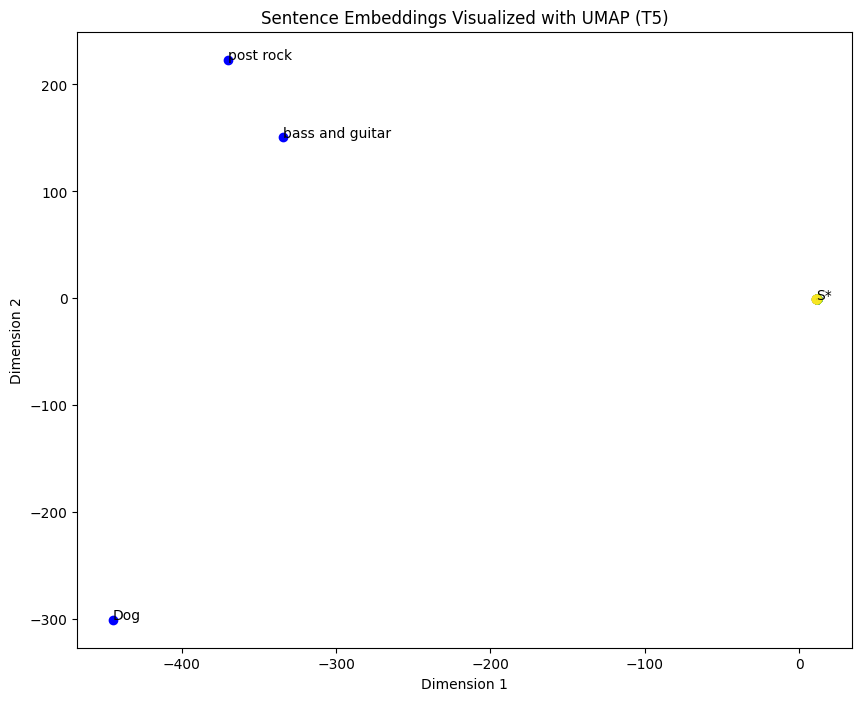

In [37]:
# Tokenize sentences
inputs = tokenizer(sentences, return_tensors='pt', padding=True, add_special_tokens=False)

# Get encoder outputs
with torch.no_grad():
	outputs= text_model.encoder.embed_tokens(inputs['input_ids'])
# outputs = text_model(**inputs)


# Compute attention mask
attention_mask = inputs['attention_mask']
attention_mask_expanded = attention_mask.unsqueeze(-1).expand(outputs.size()).float()

# Average pooling
sum_embeddings = torch.sum(outputs * attention_mask_expanded, dim=1)
sum_mask = torch.clamp(attention_mask_expanded.sum(dim=1), min=1e-9)
sentence_embeddings = sum_embeddings / sum_mask

# Convert to NumPy
sentence_embeddings = sentence_embeddings.cpu().numpy()

# Dimensionality reduction
dim_input = np.concatenate([np.stack(target_path), sentence_embeddings])
# reducer = umap.UMAP(n_neighbors=5, n_components=2, metric='cosine')
# embeddings_2d = reducer.fit_transform(dim_input)
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(dim_input)

# Plotting
sentence_idx = len(target_path)
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[sentence_idx:, 0], embeddings_2d[sentence_idx:, 1], c='blue')

for i, sentence in enumerate(sentences):
	plt.annotate(sentence, (embeddings_2d[i+sentence_idx, 0], embeddings_2d[i+sentence_idx, 1]))

colors = cm.viridis(np.linspace(0, 1, sentence_idx))
colors[:, 3]=colors[:, 3]-0.5


for (x,y), c in zip(embeddings_2d[:sentence_idx], colors):
	plt.scatter(x, y, color=c)
plt.plot([x[0] for x in embeddings_2d[:sentence_idx]], [x[1] for x in embeddings_2d[:sentence_idx]], ':g', alpha=0.2)



plt.title('Sentence Embeddings Visualized with UMAP (T5)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()